In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import seaborn as sns
import urllib.request
from IPython.display import Audio, Markdown, Image

def dmd(x):
    display(Markdown(x))
    
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22

# Procesamiento de audio

## Archivo de sonido

Un archivo de sonido tiene una frecuencia de muestreo que indica cuantas muestras tiene en un segundo.
Al abrir un archivo de sonido obtenemos un array conteniendo las muestras y la frecuencia de muestreo

In [90]:
audio, frecuencia_muestreo = librosa.load('data/SopSax.NoVib.mf.C4B4.wav', sr=None, offset=0.8, duration=3.5) # podemos cargar solo un segmento especificando inicio (offset) y duración 
dmd('### Dimensiones del array')
display(audio.shape)

dmd('### Frecuencia de muestreo')
display(frecuencia_muestreo)

### Dimensiones del array

(154350,)

### Frecuencia de muestreo

44100

Para graficar la forma de onda generamos un array con los tiempos de cada muestra

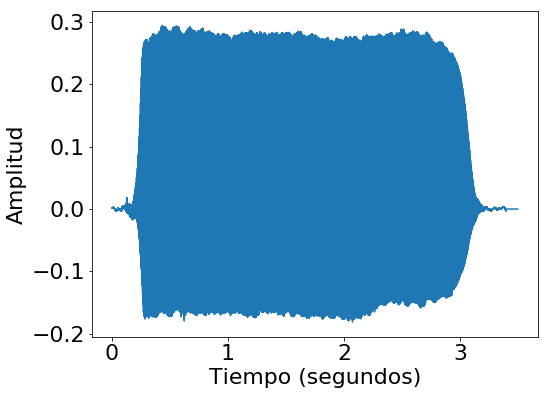

In [91]:
t = librosa.samples_to_time(np.arange(audio.size),frecuencia_muestreo)
plt.plot(t,audio)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud');
Audio(audio,rate=frecuencia_muestreo) # permite escuchar en el browser

In [92]:
# Así se escribe una sinusoide de 440 hertz
# audio = np.sin(2*np.pi*440*t)

## Análisis espectral

Para computar el espectro de una señal con valores reales, utilizamos la función rfft. Para calcular la potencia por frecuencia en decibeles se normaliza el resultado de rfft y se computa 10*log10 del módulo del espectro al cuadrado.

$$ \displaystyle P_{db} = 10 log_{10}(2|rfft(x)|^2/N) $$

### Dimensiones de RFFT

(77176,)

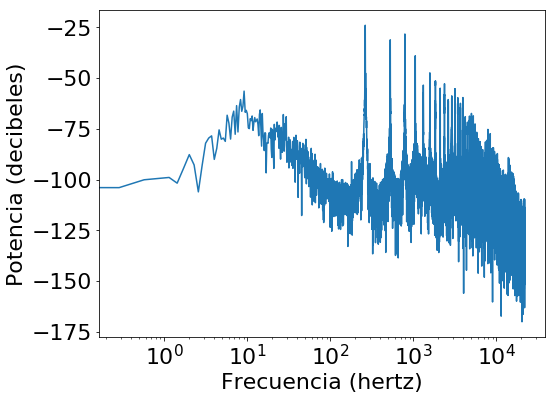

In [93]:
espectro = 10*np.log10(np.abs(2*np.fft.rfft(audio)/audio.size)**2)

dmd('### Dimensiones de RFFT')
display(espectro.shape)

frecuencias = librosa.fft_frequencies(sr=frecuencia_muestreo, n_fft=audio.size)

plt.semilogx(frecuencias, espectro)
# plt.ylim(-10,1)
plt.xlabel('Frecuencia (hertz)')
plt.ylabel('Potencia (decibeles)');

Para computar un espectrograma utilizamos la función stft (con los parámetros de tamaño de ventana y salto por defecto). La pasamos a decibeles con la funcion amplitude_to_db y la graficamos con specshow

### Dimensiones de STFT

(1025, 302)

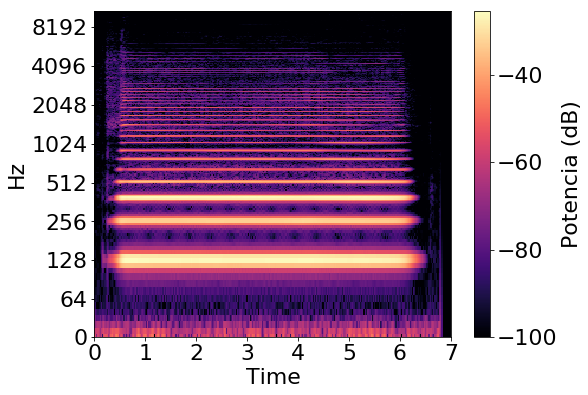

In [94]:
plt.figure()
tamaño_ventana = 2048
espectrograma = librosa.amplitude_to_db(np.abs(2*librosa.stft(audio,n_fft=tamaño_ventana)/tamaño_ventana ))

dmd('### Dimensiones de STFT')
display(espectrograma.shape)

librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
plt.colorbar(label='Potencia (dB)');

## Filtrado espectral

La stft es invertible y se puede recuperar el sonido con la istft (inversa). Se puede filtrar porciones del espectrograma modificando los valores del array

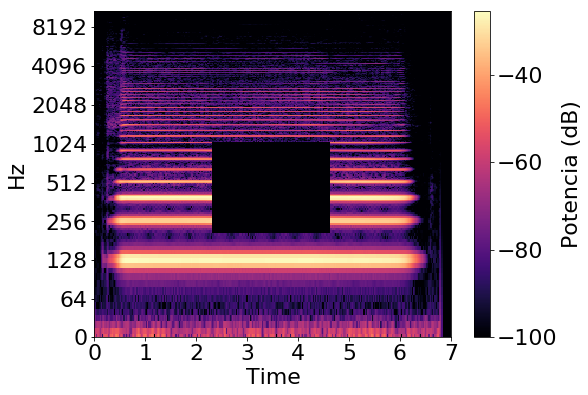

In [125]:
stft = librosa.stft(audio,n_fft=tamaño_ventana, hop_length=tamaño_ventana//4)

stft[20:100,100:200] = 0

espectrograma = librosa.amplitude_to_db(np.abs(2*stft/tamaño_ventana ))

librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
plt.colorbar(label='Potencia (dB)');

audio_filtrado = librosa.istft(stft,hop_length=tamaño_ventana//4)
Audio(audio_filtrado,rate=frecuencia_muestreo)

In [101]:
# Borrar todo pero conservar un sólo armónico
# stft = librosa.stft(audio,n_fft=tamaño_ventana, hop_length=tamaño_ventana//4)
# mascara = np.ones_like(stft,dtype=np.bool)
# mascara[22:28,:] = False
# stft[mascara] = 0
# espectrograma = librosa.amplitude_to_db(np.abs(2*stft/tamaño_ventana ))
# librosa.display.specshow(espectrograma, x_axis='time', y_axis='log')
# plt.colorbar(label='Potencia (dB)');
# audio_filtrado = librosa.istft(stft,hop_length=tamaño_ventana//4)
# Audio(audio_filtrado,rate=frecuencia_muestreo)

# Spotify API

Para conectarse a la API debemos ingresar las credenciales. Para coneseguirlas entrar a [https://developer.spotify.com/dashboard](https://developer.spotify.com/dashboard), logearse y crear el Client ID. Poner un nombre y descripción arbitrarios a la App y poner sin usos comerciales. Luego copiar las clave de id y secreta del cliente

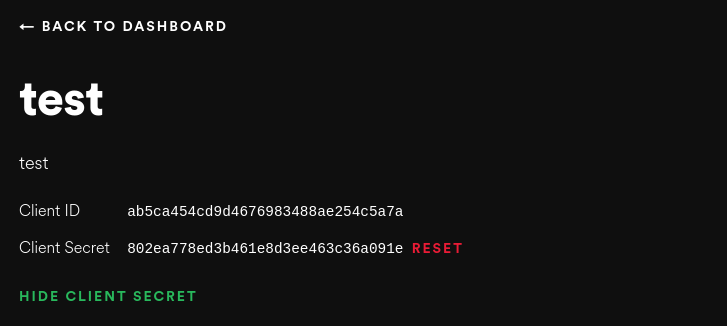

In [102]:
SPOTIFY_CLIENT_ID = 'ab5ca454cd9d4676983488ae254c5a7a'
SPOTIFY_CLIENT_SECRET = '802ea778ed3b461e8d3ee463c36a091e'

In [103]:
sp = spotipy.Spotify() 
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

Documentación de la API de spotify
[https://developer.spotify.com/documentation/](https://developer.spotify.com/documentation/)

Algunas funciones:

In [122]:
for function in [sp.search, sp.artist, sp.album, sp.tracks, sp.audio_analysis, sp.audio_features]:
    dmd('#### sp.{}():\n{}'.format(function.__name__, function.__doc__.split('\n')[0]))

#### sp.search():
 searches for an item

#### sp.artist():
 returns a single artist given the artist's ID, URI or URL

#### sp.album():
 returns a single album given the album's ID, URIs or URL

#### sp.tracks():
 returns a list of tracks given a list of track IDs, URIs, or URLs

#### sp.audio_analysis():
 Get audio analysis for a track based upon its Spotify ID

#### sp.audio_features():
 Get audio features for one or multiple tracks based upon their Spotify IDs

In [129]:
the_beatles_search = sp.search('the beatles',type='artist')

In [137]:
[item['name'] for item in the_beatles_search['artists']['items']]

['The Beatles',
 'The Tape-beatles',
 'The Norwegian Beatles',
 'Olipa kerran The Beatles',
 'Better Than The Beatles',
 'the beatles featuring mark pearson',
 'The Beatles Recovered Band',
 'The Beatles Tribute Band',
 'The Beatles Tribute Project',
 'The Beatles Greatest Hits Performed By The Frank Berman Band']

In [147]:
Image(url= the_beatles_search['artists']['items'][0]['images'][2]['url'])

In [154]:
the_beatles_id = the_beatles_search['artists']['items'][0]['id']
the_beatles_top_tracks = sp.artist_top_tracks(the_beatles_id)
[item['name'] for item in the_beatles_top_tracks['tracks']]

['Here Comes The Sun - Remastered 2009',
 'Let It Be - Remastered 2009',
 'Hey Jude - Remastered 2015',
 'Come Together - Remastered 2009',
 'Yesterday - Remastered 2009',
 'I Want To Hold Your Hand - Remastered 2015',
 'Twist And Shout - Remastered 2009',
 'In My Life - Remastered 2009',
 'Help! - Remastered 2009',
 'Blackbird - Remastered 2009']

In [161]:
the_beatles_top_tracks['tracks'][3]

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'external_urls': {'spotify': 'https://open.spotify.com/album/0ETFjACtuP2ADo6LFhL6HN'},
  'href': 'https://api.spotify.com/v1/albums/0ETFjACtuP2ADo6LFhL6HN',
  'id': '0ETFjACtuP2ADo6LFhL6HN',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/a70b5fec5600e974f58259c5639f6b20f517dd5f',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/83f0350cea2ec461499948398866400b865d0710',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/cd081bd63c6506abd59e29c04afbad14e9055e22',
    'width': 64}],
  'name': 'Abbey Road (Remastered)',
  'release_date': '1969-09-26',
  'release_date_precision': '

In [162]:
track_id = the_beatles_top_tracks['tracks'][3]['id']

# Análisis del audio

In [163]:
audio_analysis = sp.audio_analysis(track_id)
audio_analysis.keys()

In [170]:
pd.DataFrame([audio_analysis['track']]).T

,0
analysis_channels,1
analysis_sample_rate,22050
code_version,3.15
codestring,eJxdmwly7DYMRK8yRxB38v4Xy3tN2Z6fSlUS0RIXEGg0lj...
duration,259.947
echoprint_version,4.12
echoprintstring,eJzFvQuO5TqSZTslSRRJcTj8iPMfQq_FKKCqGhDPw3Mkur...
end_of_fade_in,1.00295
key,9
key_confidence,0.637


In [174]:
segments = pd.DataFrame(audio_analysis['segments'])
segments

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,0.000,1.00295,NaN,-60.000,0.00000,-60.000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.00000,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
1,1.000,0.35197,NaN,-8.329,0.14114,-60.000,"[0.469, 0.664, 1.0, 0.555, 0.238, 0.1, 0.152, ...",1.00295,"[34.236, 181.432, -51.845, -147.112, -36.499, ..."
2,0.311,0.08299,NaN,-18.589,0.00743,-27.067,"[0.621, 1.0, 0.811, 0.797, 0.259, 0.261, 0.076...",1.35492,"[35.487, 10.762, -118.892, -15.933, -38.73, -9..."
3,1.000,0.23424,NaN,-9.653,0.05398,-27.939,"[0.075, 0.68, 1.0, 0.275, 0.116, 0.063, 0.022,...",1.43791,"[40.541, 51.942, -83.987, -54.065, -25.656, 64..."
4,0.433,0.13673,NaN,-17.113,0.03145,-25.359,"[0.333, 1.0, 0.202, 0.025, 0.006, 0.007, 0.009...",1.67215,"[37.301, 35.653, -118.489, -28.661, -39.881, -..."
5,0.318,0.15465,NaN,-20.825,0.00006,-26.610,"[0.308, 1.0, 0.755, 0.13, 0.104, 0.316, 0.244,...",1.80889,"[37.33, 15.416, -116.987, -89.416, -27.551, -6..."
6,0.044,0.10136,NaN,-19.930,0.00983,-23.802,"[0.254, 1.0, 0.977, 0.46, 0.204, 0.045, 0.513,...",1.96354,"[37.886, 10.214, -135.926, -73.926, -6.857, -6..."
7,0.333,0.11365,NaN,-19.718,0.00978,-24.650,"[0.206, 0.822, 1.0, 0.351, 0.239, 0.069, 0.126...",2.06490,"[38.126, 46.576, -151.427, -57.257, 8.604, -59..."
8,0.809,0.36730,NaN,-14.336,0.02566,-25.686,"[0.026, 0.036, 0.212, 0.022, 0.019, 1.0, 0.067...",2.17855,"[39.846, 40.195, -162.686, 40.987, 2.464, -37...."
9,0.128,0.20512,NaN,-24.965,0.02104,-28.971,"[0.104, 0.374, 0.165, 0.089, 0.125, 1.0, 0.187...",2.54585,"[31.867, -134.312, -114.132, -55.329, -6.838, ..."


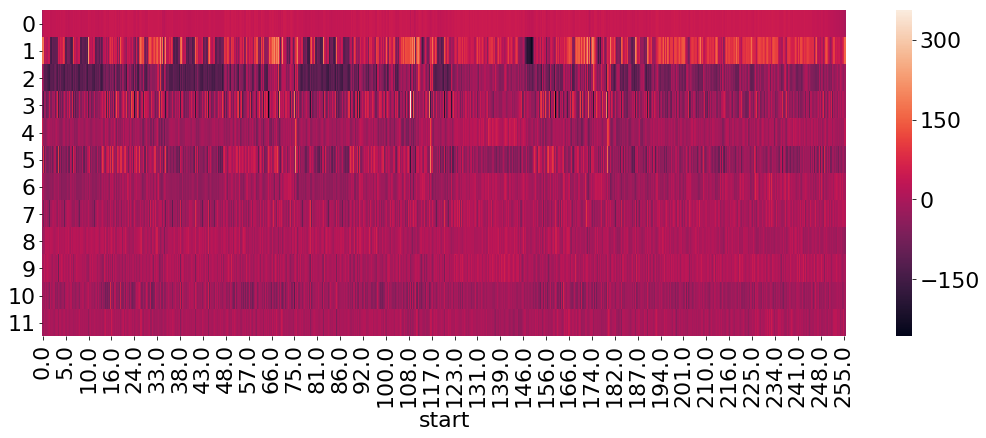

In [182]:
timbre = pd.DataFrame(np.vstack(segments.timbre), index=segments.start.round())
plt.figure(figsize=(18,6))
sns.heatmap(timbre.T);

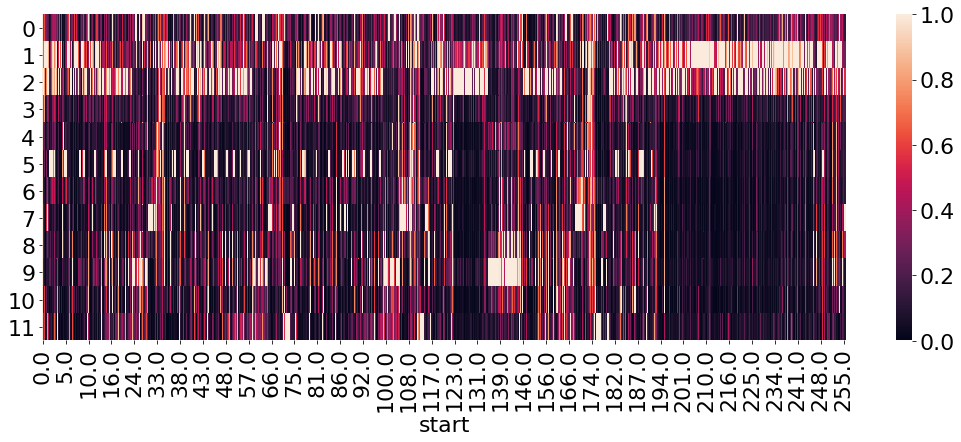

In [183]:
pitches = pd.DataFrame(np.vstack(segments.pitches), index=segments.start.round())
plt.figure(figsize=(18,6))
sns.heatmap(pitches.T);